In [2]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

2023-07-14 14:35:59.168430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#/Users/arushigupta/Desktop/Intership/Tires/Data
import Augmentor
p = Augmentor.Pipeline("/Users/arushigupta/Desktop/Intership/Data/images",output_directory="/Users/arushigupta/Desktop/Intership/output.2")

p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

p.sample(8000)  

Initialised with 40 image(s) found.
Output directory set to /Users/arushigupta/Desktop/Intership/output.2.

Processing <PIL.Image.Image image mode=RGB size=264x264 at 0x1F5E11AB0>: 100%|██████████| 8000/8000 [00:34<00:00, 229.03 Samples/s]                    


In [3]:
import pathlib
data_dir = pathlib.Path('/Users/arushigupta/Desktop/Intership/output.2')
img_height=224
img_width=224

In [4]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Metal device set to: Apple M2


2023-07-14 14:36:06.790442: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-14 14:36:06.791319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
first_image, first_label = next(iter(normalized_train_ds))
print("Pixel value range:")
print(tf.reduce_min(first_image), tf.reduce_max(first_image))

2023-07-14 14:36:14.221171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-07-14 14:36:14.221889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


Pixel value range:
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_Model1 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)

In [8]:
# Freeze the first 10 layers
for layer in base_Model1.layers[:10]:
    layer.trainable = False
x = base_Model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions1 = Dense(2, activation='softmax')(x)
Model1 = Model(inputs=base_Model1.inputs, outputs=predictions1)

In [8]:
Model2 = Sequential()#resnet

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   #input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

Model2.add(pretrained_model)
Model2.add(Flatten())
Model2.add(Dense(512, activation='relu'))
Model2.add(Dense(2, activation='sigmoid'))




In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
model_filepath = "/Users/arushigupta/Desktop/Intership/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [12]:
Model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

Model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [13]:
history1=Model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


2023-07-14 12:29:17.314924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-07-14 12:29:17.315167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
/Users/arushigupta/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logi

200/200 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9795

2023-07-14 12:35:30.477506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-07-14 12:35:30.479064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-07-14 12:35:31.368690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 383s 2s/step - loss: 0.0719 - accuracy: 0.9795 - val_loss: 3.1365 - val_accuracy: 0.7619
Epoch 2/5
200/200 [==============================] - 359s 2s/step - loss: 0.0219 - accuracy: 0.9953 - val_loss: 66.3475 - val_accuracy: 0.2662
Epoch 3/5
200/200 [==============================] - 323s 2s/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 4/5
200/200 [==============================] - 1357s 7s/step - loss: 3.2940e-04 - accuracy: 0.9998 - val_loss: 1.0048e-05 - val_accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 414s 2s/step - loss: 3.2565e-05 - accuracy: 1.0000 - val_loss: 3.7897e-06 - val_accuracy: 1.0000


In [1]:
Model1.save('Model1.h5')

NameError: name 'Model1' is not defined

/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_2423/948309460.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'r', label='Training accuracy', color='thistle')
/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_2423/948309460.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='orange')


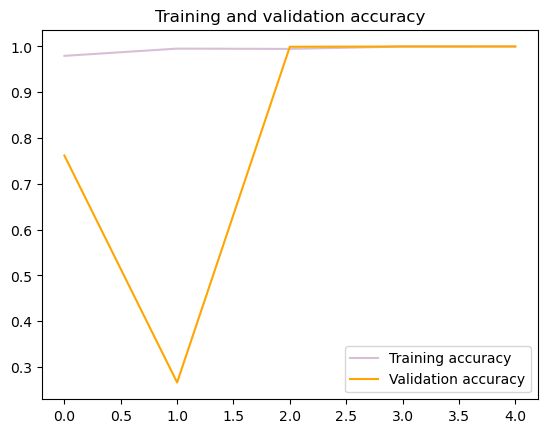

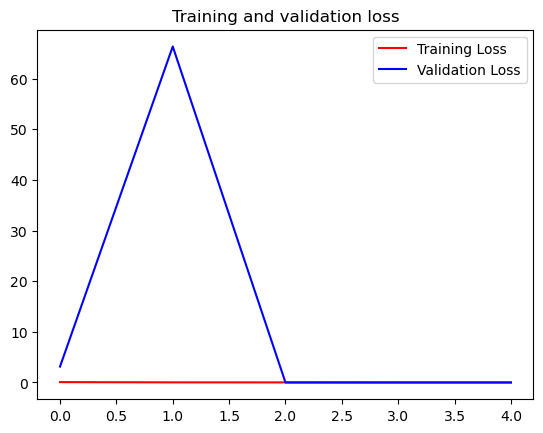

In [15]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy', color='thistle')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='orange')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
history2=Model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


2023-07-14 14:38:38.462029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2023-07-14 14:38:38.462334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
/Users/arushigupta/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits

200/200 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.4931

2023-07-14 14:39:48.678701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-07-14 14:39:48.680192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-07-14 14:39:49.444636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 84s 389ms/step - loss: 0.0219 - accuracy: 0.4931 - val_loss: 2.6979e-05 - val_accuracy: 0.5094
Epoch 2/5
200/200 [==============================] - 85s 425ms/step - loss: 2.2061e-05 - accuracy: 0.4931 - val_loss: 1.2550e-05 - val_accuracy: 0.5094
Epoch 3/5
200/200 [==============================] - 77s 385ms/step - loss: 1.0183e-05 - accuracy: 0.4931 - val_loss: 7.3643e-06 - val_accuracy: 0.5094
Epoch 4/5
200/200 [==============================] - 79s 397ms/step - loss: 6.0239e-06 - accuracy: 0.4931 - val_loss: 4.6110e-06 - val_accuracy: 0.5094
Epoch 5/5
200/200 [==============================] - 74s 370ms/step - loss: 3.9802e-06 - accuracy: 0.4931 - val_loss: 3.2283e-06 - val_accuracy: 0.5094


In [16]:
Model2.save('Model2.h5')

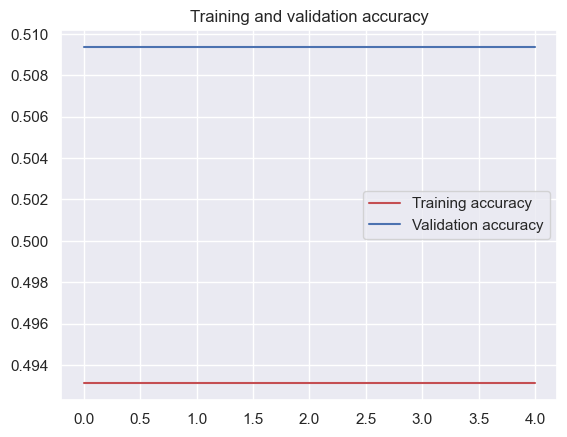

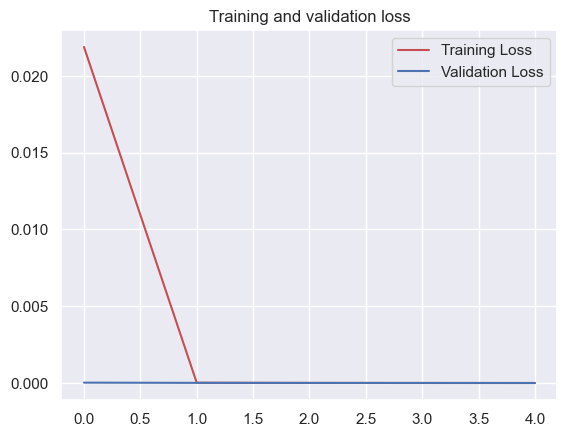

NameError: name 'target_names' is not defined

In [18]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap( annot=True, cmap='winter', cbar=False, linewidths=3, linecolor='r', square=True,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values ');

In [19]:
#Ensemble
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/Users/arushigupta/Desktop/Intership/Model1.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/Users/arushigupta/Desktop/Intership/Model2.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [20]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy']) 

In [21]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5)

Epoch 1/5


2023-07-14 14:47:18.063789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9966

2023-07-14 14:54:24.612524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 458s 2s/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.0694 - val_accuracy: 0.9869
Epoch 2/5
200/200 [==============================] - 456s 2s/step - loss: 0.0113 - accuracy: 0.9927 - val_loss: 0.0946 - val_accuracy: 0.9794
Epoch 3/5
200/200 [==============================] - 435s 2s/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0289 - val_accuracy: 0.9731
Epoch 4/5
200/200 [==============================] - 525s 3s/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/5
200/200 [==============================] - 585s 3s/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.1137 - val_accuracy: 0.9712


In [26]:
# Obtain predictions from the ensemble model
Y_pred = ensemble_model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

50/50 [==============================] - 18s 349ms/step


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['cracked', 'normal']
print(classification_report(test_label, y_pred, target_names=target_names))

/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_1030/3402159640.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix


NameError: name 'test_label' is not defined

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['cracked', 'normal']
print(classification_report(test_label, y_pred, target_names=target_names))


/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_1030/2636338136.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix


NameError: name 'test_label' is not defined

In [23]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(5600,)
(2400,)


In [31]:
ensemble_model.save('ensemble_model.h5')

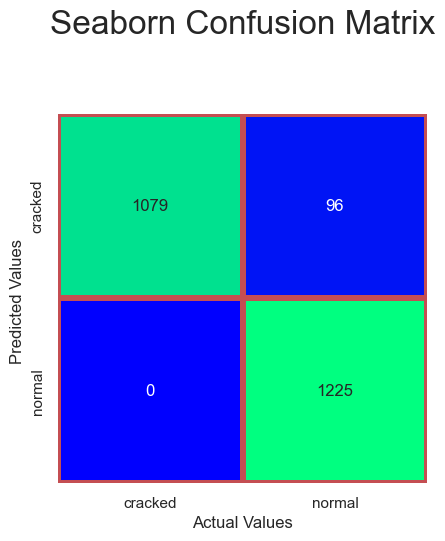

In [27]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='winter', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values ');

In [34]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)









from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['cracked', 'normal']
print(classification_report(test_label, y_pred, target_names=target_names))

(6400,)
(1600,)


/var/folders/py/xhjr5n9s729_02xr2vxm8km80000gn/T/ipykernel_1030/1837506863.py:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 1600)


Confusion Matrix
[[815   0]
 [ 46 739]]
Classification Report
              precision    recall  f1-score   support

     cracked       0.95      1.00      0.97       815
      normal       1.00      0.94      0.97       785

    accuracy                           0.97      1600
   macro avg       0.97      0.97      0.97      1600
weighted avg       0.97      0.97      0.97      1600

